<a href="https://colab.research.google.com/github/bypolyarka/home-credit-kaggle/blob/master/home_credit_default_risk.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* application_train/application_test: Основные данные, заемщик идентифицируется по полю SK_ID_CURR

* bureau: Данные по предыдущим займам в других кредитных организациях из кредитного бюро

* bureau_balance: Ежемесячные данные по предыдущим кредитам по бюро. Каждая строка — месяц испльзования кредита

* previous_application: Предыдущие заявки по кредитам в Home Credit, каждая имеет уникальное поле SK_ID_PREV

* POS_CASH_BALANCE: Ежемесячные данные по кредитам в Home Creditс выдачей наличными и кредитам на покупки товаров

* credit_card_balance: Ежемесячные данные по балансу кредитных карт в Home Credit

* installments_payment: Платежная история предыдущих займов в Home Credit.

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import LabelEncoder

In [4]:
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')
print ("формат обучающей выборки:", app_train.shape)
print ("формат тестовой выборки:", app_test.shape)

формат обучающей выборки: (307511, 122)
формат тестовой выборки: (48744, 121)


In [5]:
# app_train.info(max_cols=122)

## Exploratory Data Analysis

### Распределение целевой переменной

In [6]:
app_train.TARGET.value_counts()

0    282686
1     24825
Name: TARGET, dtype: int64

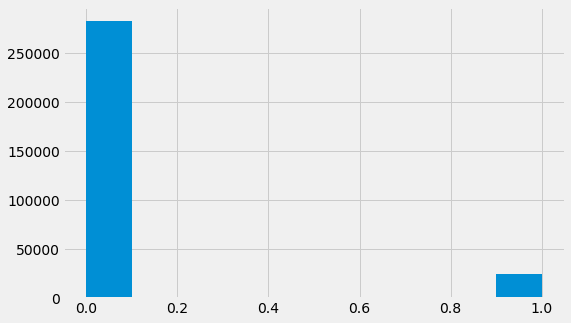

In [7]:
plt.style.use('fivethirtyeight')
plt.rcParams["figure.figsize"] = [8,5]
plt.hist(app_train.TARGET)
plt.show()

1 означает проблемы любого рода с возвратом, 0 - отсутствие проблем

Видим, что классы несбалансированны.

## Пропуски в данных

In [8]:
def missing_values_table(df):
    ''' Функция для подсчета недостающих данных по столбцам столбцам
    '''

    # Всего недостает
    mis_val = df.isnull().sum()

    # Процент недостающих данных
    mis_val_percent = 100 * df.isnull().sum() / len(df)

    # Таблица с результатами
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)

    # Переименование столбцов
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})

    # Сортировка по процентажу
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)

    # Инфо
    print ("В выбранном датафрейме " + str(df.shape[1]) + " столбцов.\n"      
        "Всего " + str(mis_val_table_ren_columns.shape[0]) +
          " столбцов с неполными данными.")

    # Возврат таблицы с данными
    return mis_val_table_ren_columns
    
missing_values = missing_values_table(app_train)
missing_values.head(10)

В выбранном датафрейме 122 столбцов.
Всего 67 столбцов с неполными данными.


,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


Text(0.5, 0, 'Столбцы')

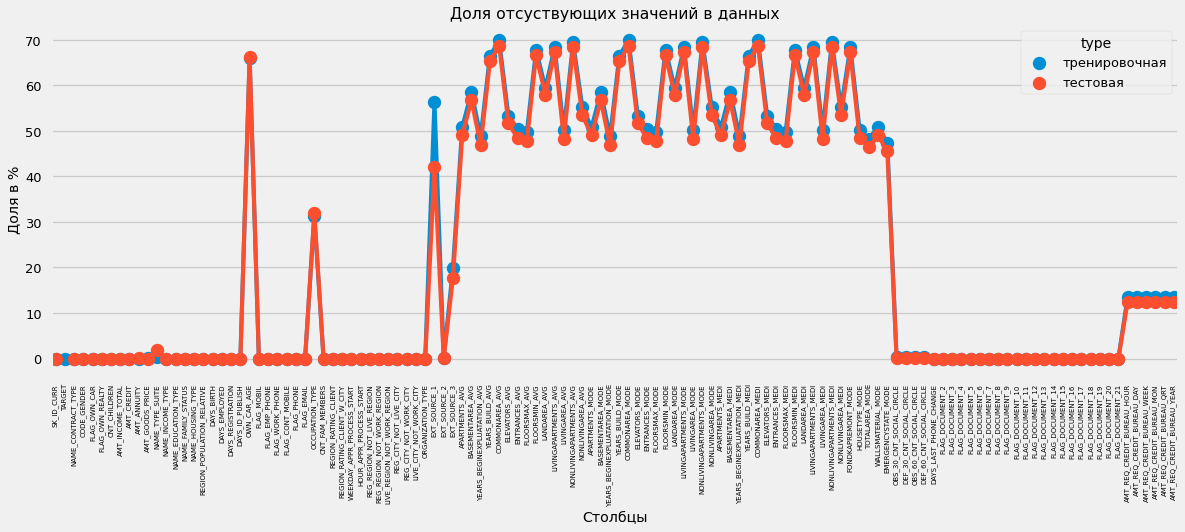

In [9]:
plt.style.use('seaborn-talk')
fig = plt.figure(figsize=(18,6))

miss_train = pd.DataFrame((app_train.isnull().sum())*100/app_train.shape[0]).reset_index()
miss_test = pd.DataFrame((app_test.isnull().sum())*100/app_test.shape[0]).reset_index()
miss_train["type"] = "тренировочная"
miss_test["type"] = "тестовая"
missing = pd.concat([miss_train,miss_test], axis=0)
ax = sns.pointplot("index", 0, data=missing, hue="type")
plt.xticks(rotation=90, fontsize=7)
plt.title("Доля отсуствующих значений в данных")
plt.ylabel("Доля в %")
plt.xlabel("Столбцы")

### Типы столбцов и кодирование категориальных данных

In [10]:
app_train.dtypes.value_counts()

float64    65
int64      41
object     16
dtype: int64

In [11]:
categorical_features = app_train.select_dtypes(include=[object]).apply(pd.Series.nunique, axis=0)
categorical_features

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

16 столбцов, в каждом из которых от 2 до 58 разных фич.
Бинарные категориальные признаки закодируем с помощью LabelEncoder, все остальные - с помощью OneHotEncoding.

In [12]:
dataset = pd.concat([app_train, app_test])

In [13]:
le = LabelEncoder()

for col in categorical_features[categorical_features==2].index:
#     app_train[col] = le.fit_transform(app_train[col].astype('str'))
#     app_test[col]  = le.transform(app_test[col].astype('str'))
    dataset[col] = le.fit_transform(dataset[col].astype('str'))

In [14]:
# app_train['CODE_GENDER'].value_counts()  # XNA - ???

In [15]:
dataset = pd.get_dummies(dataset)

train = dataset.iloc[:len(app_train), :]
test = dataset.iloc[len(app_train):, :]

In [16]:
del dataset

Y = train['TARGET']
train.drop(columns=['TARGET'], inplace=True)
test.drop(columns=['TARGET'], inplace=True)

print('Train shape: ', train.shape)
print('Test shape: ', test.shape)

Train shape:  (307511, 241)
Test shape:  (48744, 241)


### Корреляция в данных

Рассчитаем коэффициенты коррелации Пирсона для данных относительно целевого признака.

In [17]:
# Кореляция и сротировка
correlations = app_train.corr()['TARGET'].sort_values()

print('Наивысшая позитивная корреляция: \n', correlations.tail(15))
print('\n\nНаивысшая негативная коррелация: \n', correlations.head(15))

Наивысшая позитивная корреляция: 
 DEF_60_CNT_SOCIAL_CIRCLE       0.031276
DEF_30_CNT_SOCIAL_CIRCLE       0.032248
LIVE_CITY_NOT_WORK_CITY        0.032518
OWN_CAR_AGE                    0.037612
DAYS_REGISTRATION              0.041975
FLAG_DOCUMENT_3                0.044346
REG_CITY_NOT_LIVE_CITY         0.044395
FLAG_EMP_PHONE                 0.045982
REG_CITY_NOT_WORK_CITY         0.050994
DAYS_ID_PUBLISH                0.051457
DAYS_LAST_PHONE_CHANGE         0.055218
REGION_RATING_CLIENT           0.058899
REGION_RATING_CLIENT_W_CITY    0.060893
DAYS_BIRTH                     0.078239
TARGET                         1.000000
Name: TARGET, dtype: float64


Наивысшая негативная коррелация: 
 EXT_SOURCE_3                 -0.178919
EXT_SOURCE_2                 -0.160472
EXT_SOURCE_1                 -0.155317
DAYS_EMPLOYED                -0.044932
FLOORSMAX_AVG                -0.044003
FLOORSMAX_MEDI               -0.043768
FLOORSMAX_MODE               -0.043226
AMT_GOODS_PRICE           

Видно, что данные слабо коррелируют с целевой переменной. 
Но есть смысл выделить некоторые переменные, такие как: возраст DAYS_BIRTH и какие-то внешние источники EXT_SOURCE_*


### Возраст DAYS_BIRTH

In [18]:
# train['DAYS_BIRTH']
train['DAYS_BIRTH'] = train['DAYS_BIRTH'].abs()
test['DAYS_BIRTH'] = test['DAYS_BIRTH'].abs()
train['DAYS_BIRTH'].corr(app_train['TARGET'])

-0.07823930830982694

Самому младшему заёмщику 21 лет.
Самому старшему заёмщику 69 лет.


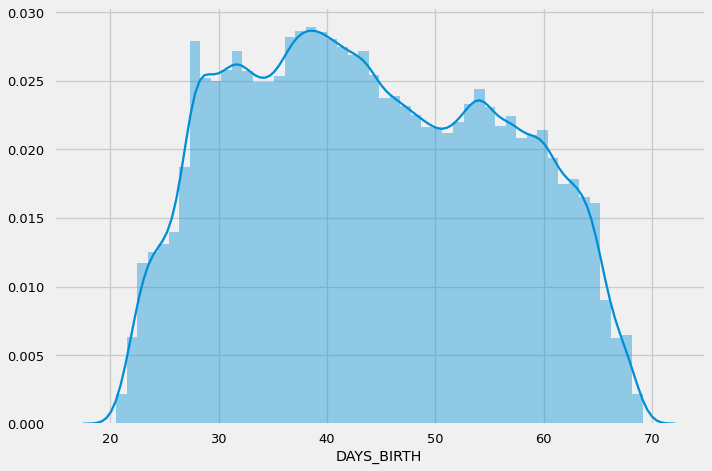

In [19]:
sns.distplot(train['DAYS_BIRTH'] / 365)
print('Самому младшему заёмщику {age} лет.'.format(age=round(train['DAYS_BIRTH'].min() / 365)))
print('Самому старшему заёмщику {age} лет.'.format(age=round(train['DAYS_BIRTH'].max() / 365)))

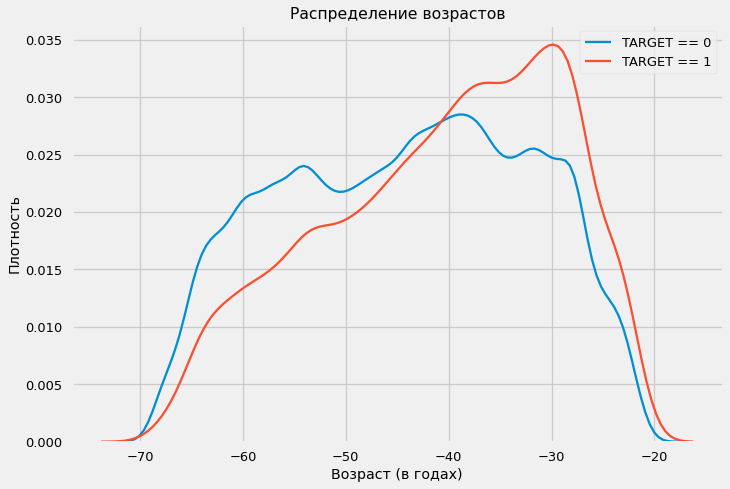

In [20]:
# KDE займов, выплаченных вовремя
sns.kdeplot(app_train.loc[app_train['TARGET']==0, 'DAYS_BIRTH'] / 365, label='TARGET == 0')

# KDE проблемных займов
sns.kdeplot(app_train.loc[app_train['TARGET']==1, 'DAYS_BIRTH'] / 365, label='TARGET == 1')

# Обозначения
plt.xlabel('Возраст (в годах)'); plt.ylabel('Плотность'); plt.title('Распределение возрастов');

Доля невозвратов чуть выше для молодых людей и снижается с ростом возраста. Ничего необычного

### Внешние источники

In [21]:
ext_data = app_train[['TARGET', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
ext_data_corrs = ext_data.corr()
ext_data_corrs

,TARGET,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,DAYS_BIRTH
TARGET,1.000000,-0.155317,-0.160472,-0.178919,0.078239
EXT_SOURCE_1,-0.155317,1.000000,0.213982,0.186846,-0.600610
EXT_SOURCE_2,-0.160472,0.213982,1.000000,0.109167,-0.091996
EXT_SOURCE_3,-0.178919,0.186846,0.109167,1.000000,-0.205478
DAYS_BIRTH,0.078239,-0.600610,-0.091996,-0.205478,1.000000


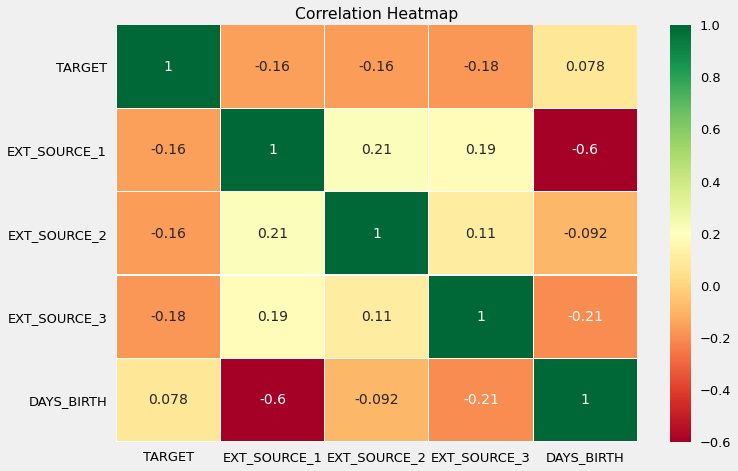

In [22]:
sns.heatmap(ext_data_corrs, annot=True, linewidth=0.2, cmap=plt.cm.RdYlGn)
plt.title('Correlation Heatmap');

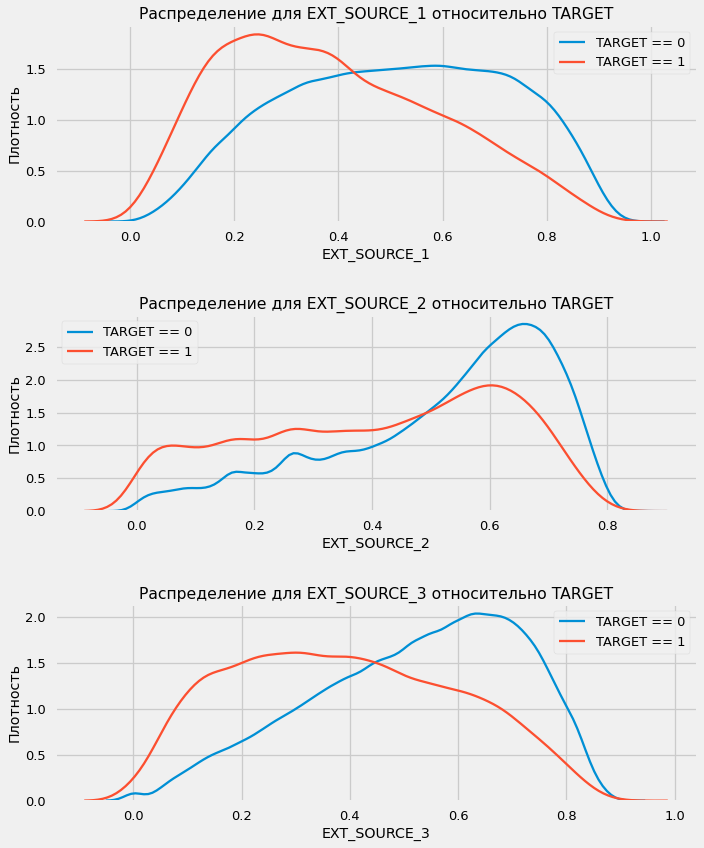

In [23]:
plt.figure(figsize = (10, 12))

for i, ext in enumerate(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']):
    plt.subplot(3, 1, i + 1)
    sns.kdeplot(app_train.loc[app_train['TARGET']==0, ext], label='TARGET == 0')
    sns.kdeplot(app_train.loc[app_train['TARGET']==1, ext], label='TARGET == 1')
    # метки
    plt.title('Распределение для {} относительно TARGET'.format(ext))
    plt.xlabel(ext); plt.ylabel('Плотность');
    
plt.tight_layout(h_pad=2.5)

Картинка схожа с возрастом - с ростом показателя растет вероятность возврата кредита.

### Исследование других признаков

В этом нам поможет функция для визуализации диаграмм

In [24]:
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = app_train[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Количество займов': temp.values})

    # Расчет доли target=1 в категории
    cat_perc = app_train[[feature, 'TARGET']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='TARGET', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Количество займов",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='TARGET', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Доля проблемных', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();

### Тип займа

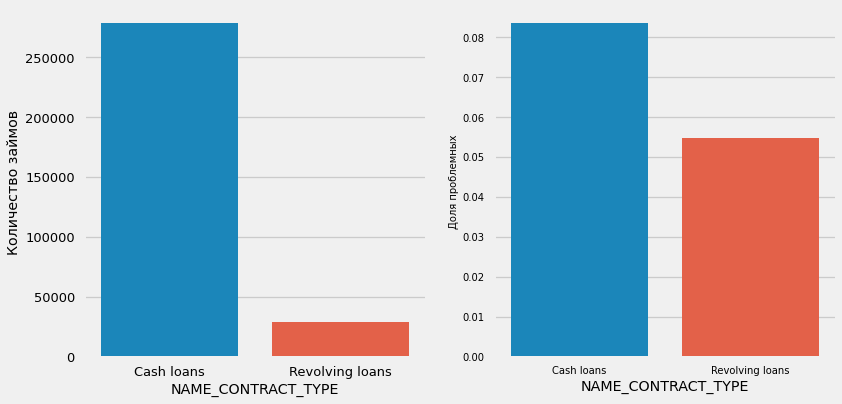

In [25]:
plot_stats('NAME_CONTRACT_TYPE')

Револьверные займы составляют меньше 10% от общего количества займов. В то же время процент невозврата среди них гораздо выше.


### Пол клиента

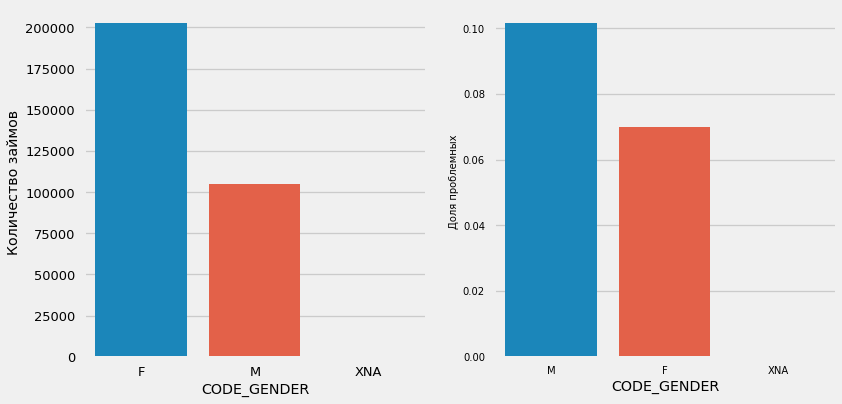

In [26]:
plot_stats('CODE_GENDER')

Женщин вдвое больше, но видно, что мужчины хуже возвращают займы.

In [27]:
app_train['CODE_GENDER'].value_counts()  # XNA - ???

F      202448
M      105059
XNA         4
Name: CODE_GENDER, dtype: int64

### Владение машиной и недвижимостью

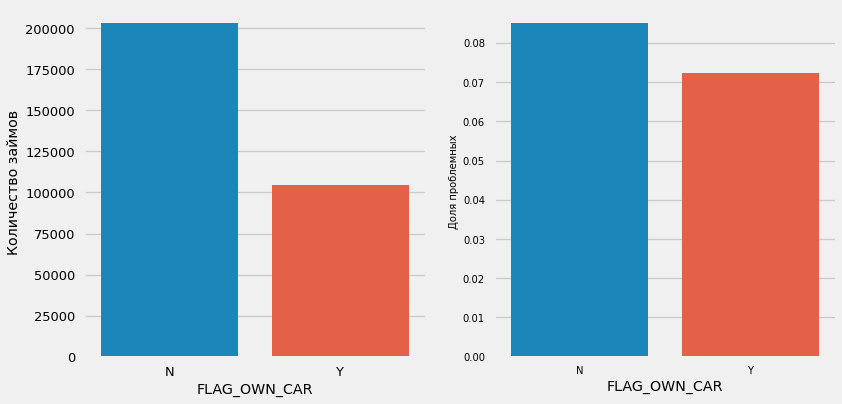

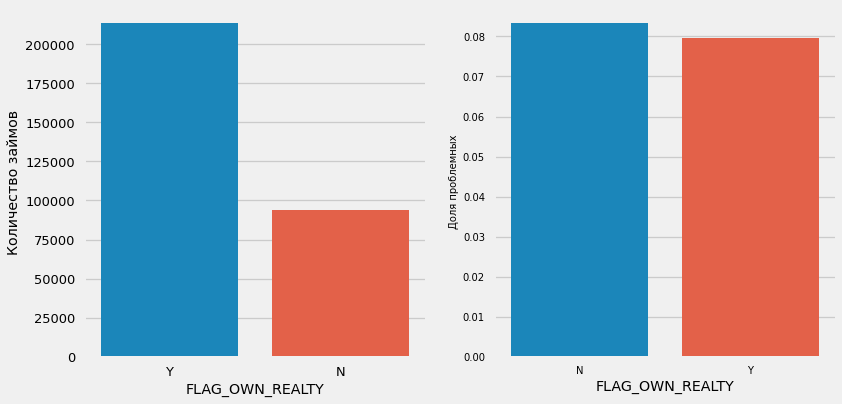

In [28]:
plot_stats('FLAG_OWN_CAR')
plot_stats('FLAG_OWN_REALTY')

Заёмщиков с машиной вдвое меньше. Риск по ним практически одинаковый, клиенты с машиной платят чуть лучше.

По недвижимости - клиентов без нее вдвое меньше. Риск по владельцам недвижимости и без неё примерно одинаковый.


### Возраст собственного автомобиля

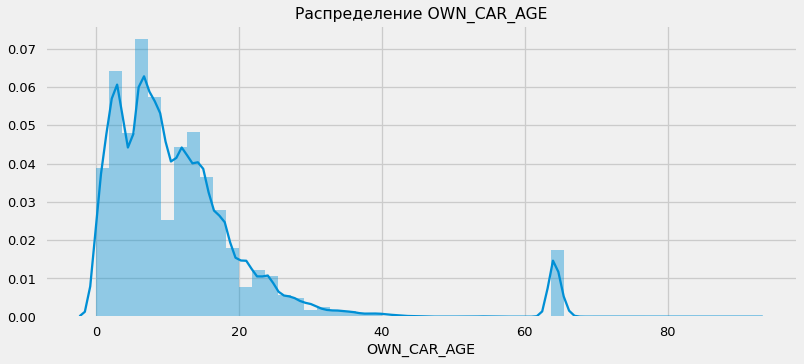

In [29]:
plt.figure(figsize=(12,5))
plt.title("Распределение OWN_CAR_AGE")
ax = sns.distplot(app_train['OWN_CAR_AGE'])

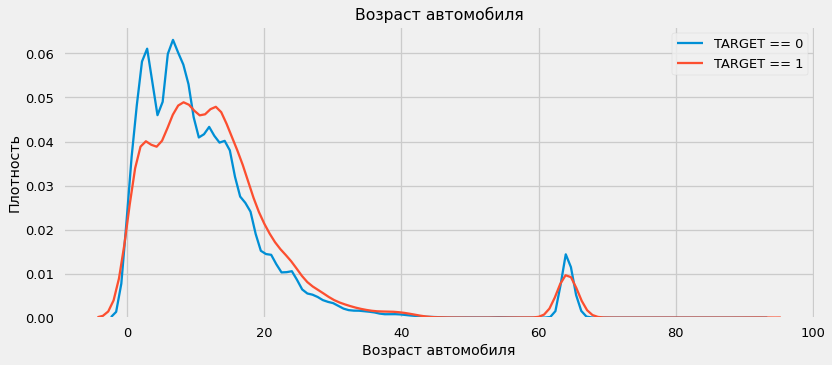

In [30]:
plt.figure(figsize=(12,5))

# KDE займов, выплаченных вовремя
sns.kdeplot(app_train.loc[app_train['TARGET']==0, 'OWN_CAR_AGE'], label='TARGET == 0')

# KDE проблемных займов
sns.kdeplot(app_train.loc[app_train['TARGET']==1, 'OWN_CAR_AGE'], label='TARGET == 1')

# Обозначения
plt.xlabel('Возраст автомобиля'); plt.ylabel('Плотность'); plt.title('Возраст автомобиля');


Клиенты с машинами старше 10 лет возвращают кредит немного хуже, чем владельцы автомобилей младше 10 лет. Вероятно, старые авто требуют более частых затрат на ремонт и обслуживание.


### Тип жилья

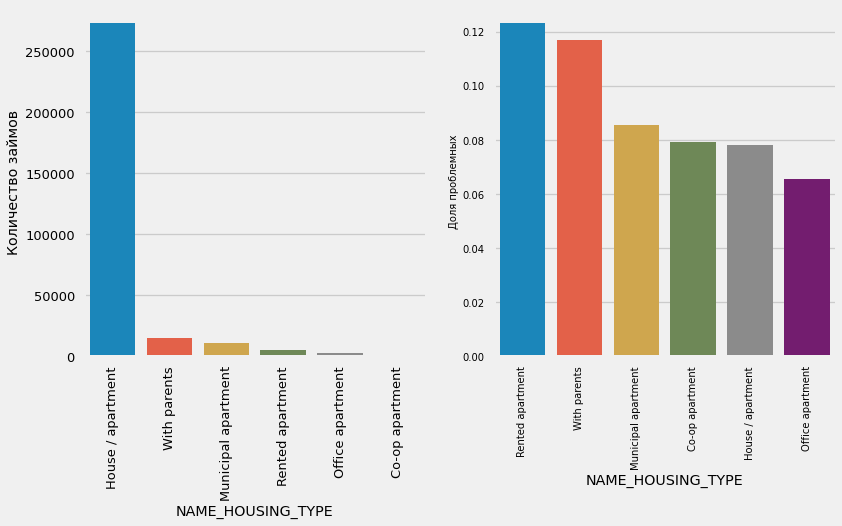

In [31]:
plot_stats('NAME_HOUSING_TYPE', True)

Любопытный факт, что люди, живущие с родителями и арендующие жилье, при малом их количестве возвращают кредит почти одинаково хуже остальных. Такая же ситуация и с муниципальным жильём. 

### Семейный статус

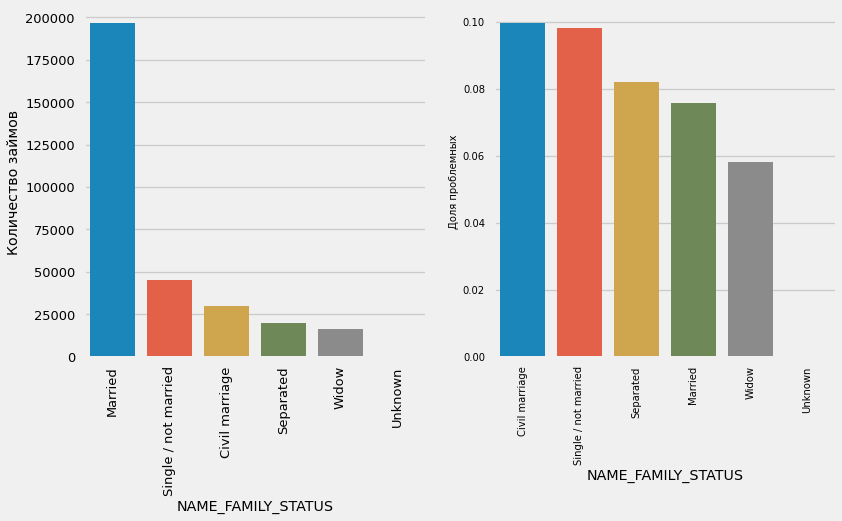

In [32]:
plot_stats('NAME_FAMILY_STATUS', True, True)

В то время как большинство клиентов состоит в браке, ниаболее рискованы клиенты в гражданском браке и одинокие. Вдовцы показывают минимальный риск.


### Количество детей

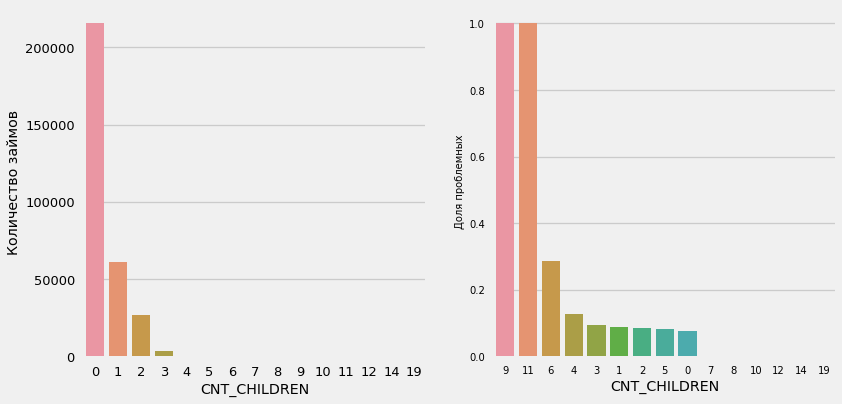

In [33]:
plot_stats('CNT_CHILDREN')

Большинство клиентов бездетны. При этом клиенты с 9 и 11 детьми показывют полный невозврат.


In [34]:
app_train['CNT_CHILDREN'].value_counts()

0     215371
1      61119
2      26749
3       3717
4        429
5         84
6         21
7          7
14         3
19         2
12         2
10         2
9          2
8          2
11         1
Name: CNT_CHILDREN, dtype: int64

Из распределения видно, что многодетность (> 5 детей) - статистически незначима (размер выборки невелик). Около 30% с 6 детьми оказались проблемными платильщиками.


### Количество членов семьи

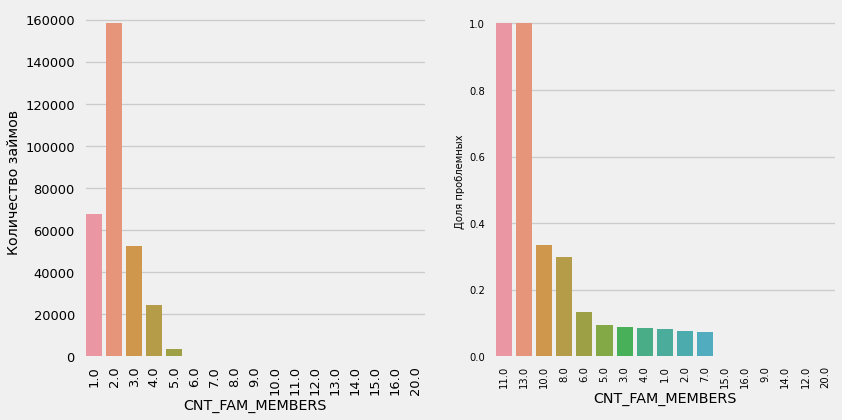

In [35]:
plot_stats('CNT_FAM_MEMBERS', True)

Чем меньше количество членов семьи, тем выше доля возврата.


### Тип дохода

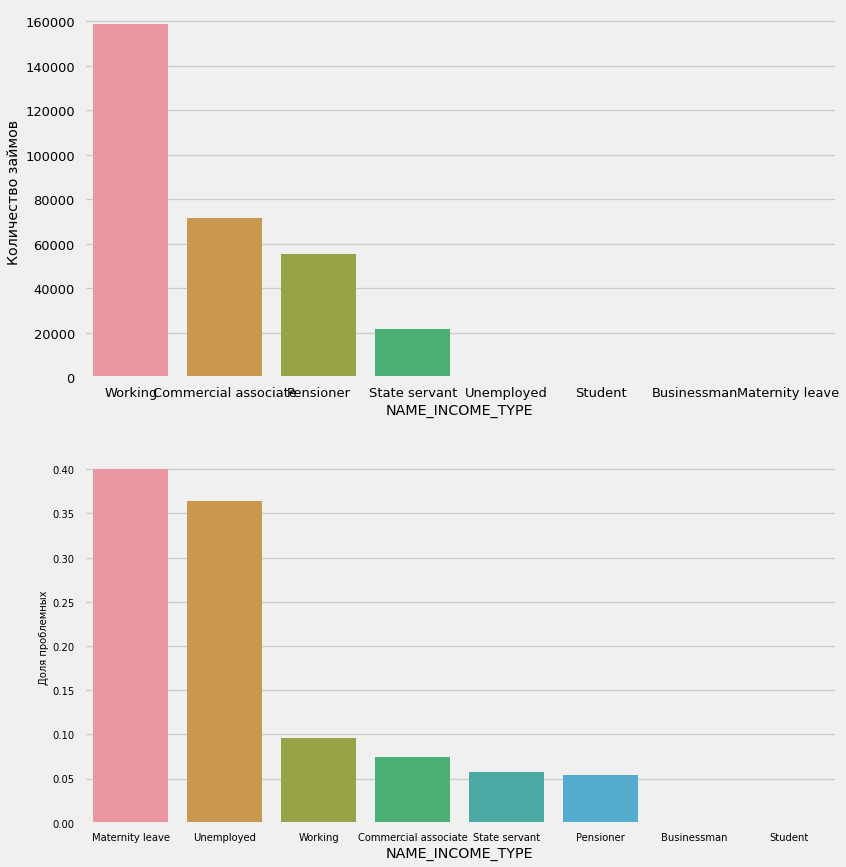

In [36]:
plot_stats('NAME_INCOME_TYPE', False, False)

Матери-одиночки и безработные, скорее всего, отсекаются на этапе подачи заявки. Но стабильно показывают проблемы.


### Вид деятельности

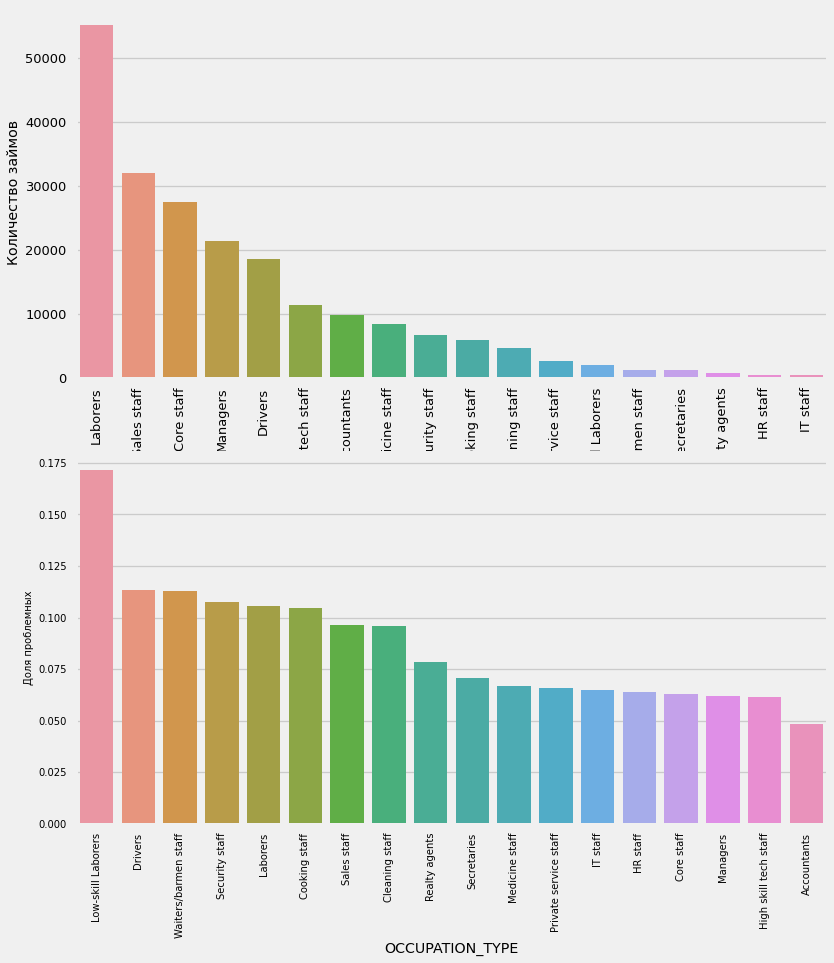

In [37]:
plot_stats('OCCUPATION_TYPE', True, False)

Проблемы с платежами возникают чаще всего у низкоквалифицированных работников при небольшом их количестве. Схожая ситуация у работников ресторанного бизнеса - официанты и бармены.

Категории водителей, сотрудников безопасности, рабочих при их большом количестве оказываются чаще проблемными заёмщиками.


### Образование

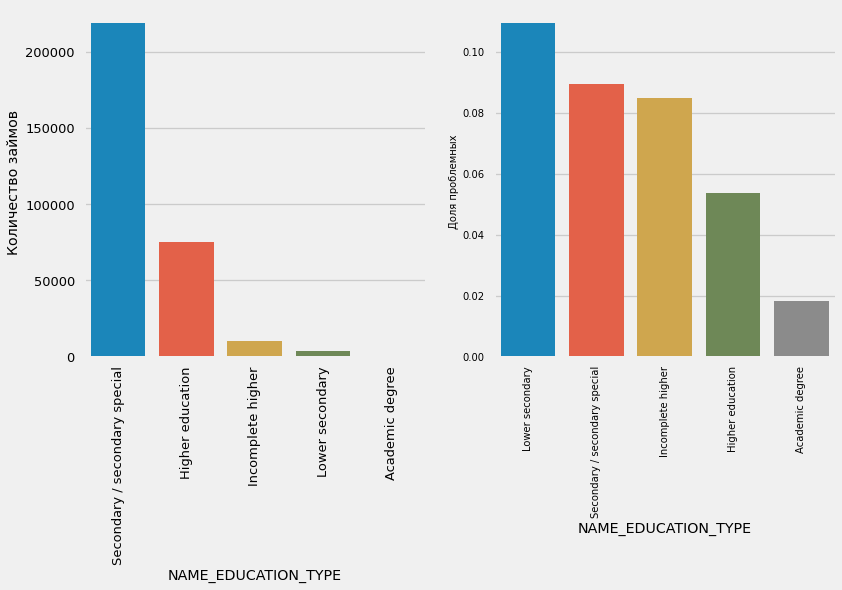

In [38]:
plot_stats('NAME_EDUCATION_TYPE', True)

Чем выше образование, тем лучше возвратность.


### Тип организации работодателя

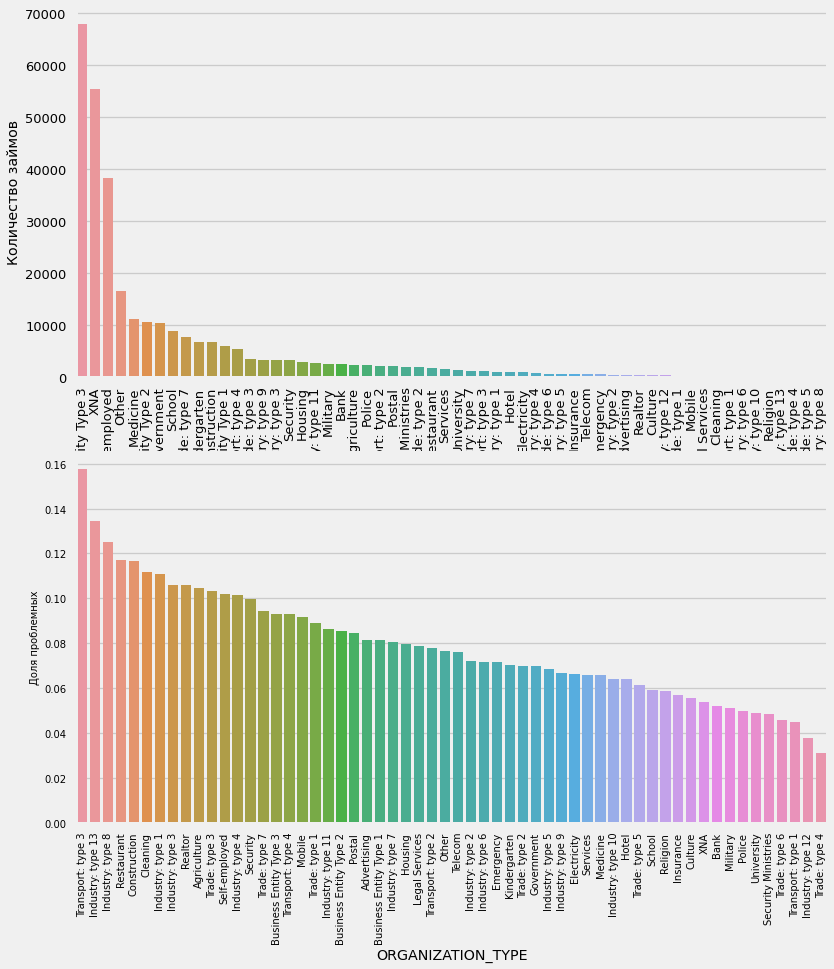

In [39]:
plot_stats('ORGANIZATION_TYPE', True, False)

Наивысший процент невозврата наблюдается в Transport: type 3 (\~16%), Industry: type 13 (\~13.5%), Industry: type 8 (\~12.5%) и в Restaurant (\~12%).


### Распределение суммы кредитования

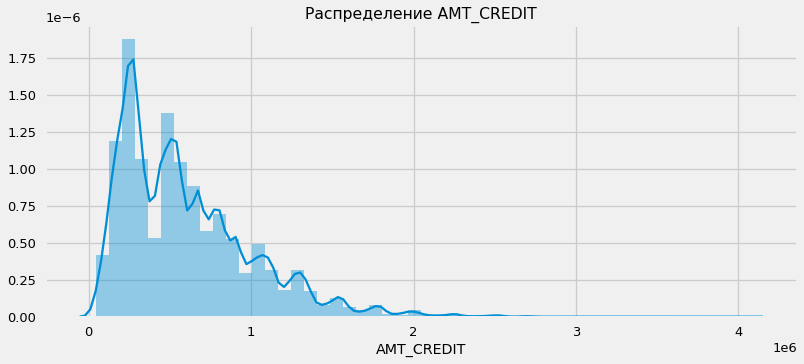

In [40]:
plt.figure(figsize=(12,5))
plt.title("Распределение AMT_CREDIT")
ax = sns.distplot(app_train['AMT_CREDIT'])

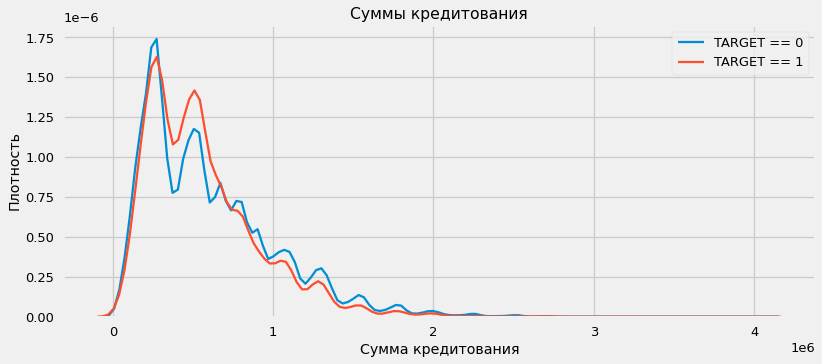

In [41]:
plt.figure(figsize=(12,5))

# KDE займов, выплаченных вовремя
sns.kdeplot(app_train.loc[app_train['TARGET']==0, 'AMT_CREDIT'], label='TARGET == 0')

# KDE проблемных займов
sns.kdeplot(app_train.loc[app_train['TARGET']==1, 'AMT_CREDIT'], label='TARGET == 1')

# Обозначения
plt.xlabel('Сумма кредитования'); plt.ylabel('Плотность'); plt.title('Суммы кредитования');


Из графика видно, что крупные суммые возвращаются чаще.


### Распределение по плотности проживания

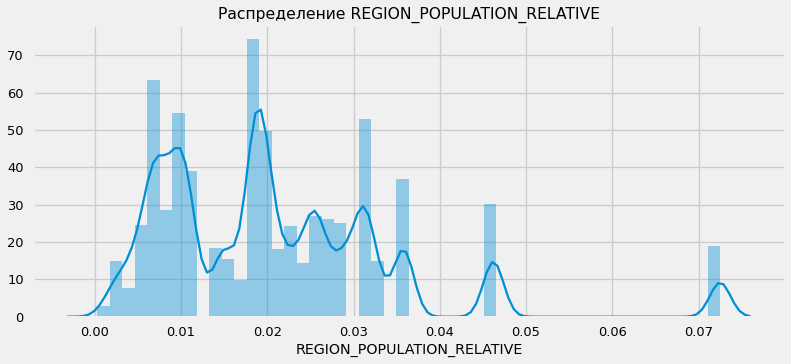

In [42]:
plt.figure(figsize=(12,5))
plt.title("Распределение REGION_POPULATION_RELATIVE")
ax = sns.distplot(app_train['REGION_POPULATION_RELATIVE'])

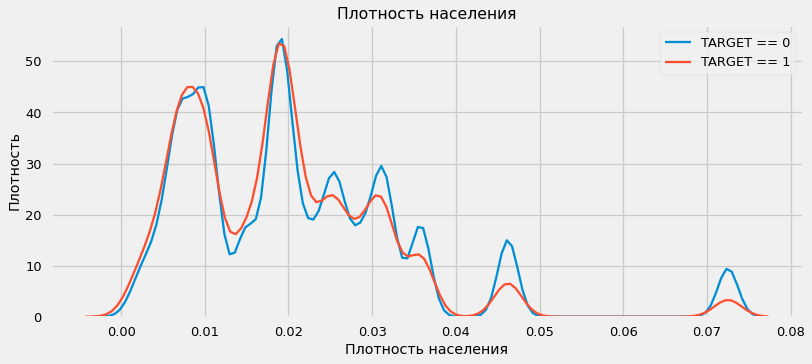

In [43]:
plt.figure(figsize=(12, 5))

# KDE займов, выплаченных вовремя
sns.kdeplot(app_train.loc[app_train['TARGET']==0, 'REGION_POPULATION_RELATIVE'], label='TARGET == 0')

# KDE проблемных займов
sns.kdeplot(app_train.loc[app_train['TARGET']==1, 'REGION_POPULATION_RELATIVE'], label='TARGET == 1')

# Обозначения
plt.xlabel('Плотность населения'); plt.ylabel('Плотность'); plt.title('Плотность населения');

Заёмщики из более населенных регионов выплачивают кредит чаще.


### Распределение по опыту работы на текущем рабочем месте

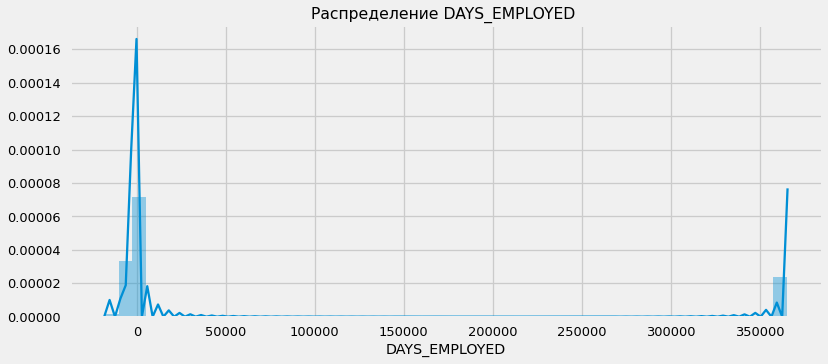

In [44]:
plt.figure(figsize=(12,5))
plt.title("Распределение DAYS_EMPLOYED ")
ax = sns.distplot(app_train['DAYS_EMPLOYED'])

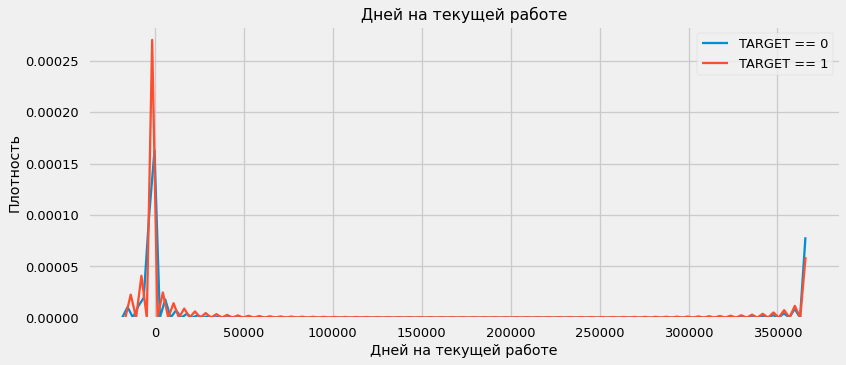

In [45]:
plt.figure(figsize=(12,5))

# KDE займов, выплаченных вовремя
sns.kdeplot(app_train.loc[app_train['TARGET']==0, 'DAYS_EMPLOYED'], label='TARGET == 0')

# KDE проблемных займов
sns.kdeplot(app_train.loc[app_train['TARGET']==1, 'DAYS_EMPLOYED'], label='TARGET == 1')

# Обозначения
plt.xlabel('Дней на текущей работе'); plt.ylabel('Плотность'); plt.title('Дней на текущей работе');

#### ???
Не совсем понятно, почему такие большие порядки. Отрицательные числа показывают, скорее всего, пенсионеры (неработающие) + студенты (неработающие) + безработные + матери-одиночки.
Явных закономерностей не наблюдется.

In [46]:
# app_train['DAYS_EMPLOYED'].abs().value_counts().sort_index()

### Наличие поручителя

In [47]:
app_train['NAME_TYPE_SUITE'].value_counts()

Unaccompanied      248526
Family              40149
Spouse, partner     11370
Children             3267
Other_B              1770
Other_A               866
Group of people       271
Name: NAME_TYPE_SUITE, dtype: int64

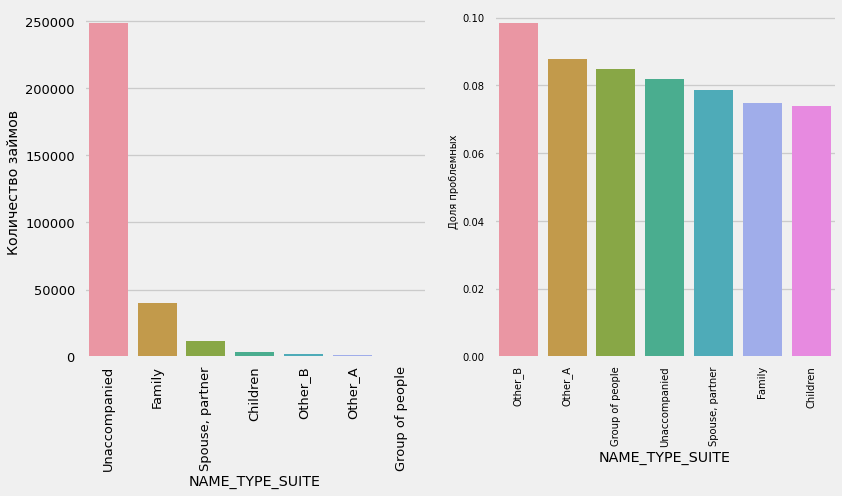

In [48]:
plot_stats('NAME_TYPE_SUITE', True)

Клиенты с поручителями Other_A, Other_B возвращают займы хуже остальных. Примерно та же ситуация с группой людей в качестве поручителя - видимо кредитору сложнее возвращать займ сразу от нескольких людей-поручителей. Лучше всего возвращают займ клиенты с детьми или семьей в качестве поручителя.

### Телефон в зоне досягаемости

In [49]:
app_train['FLAG_CONT_MOBILE'].value_counts()

1    306937
0       574
Name: FLAG_CONT_MOBILE, dtype: int64

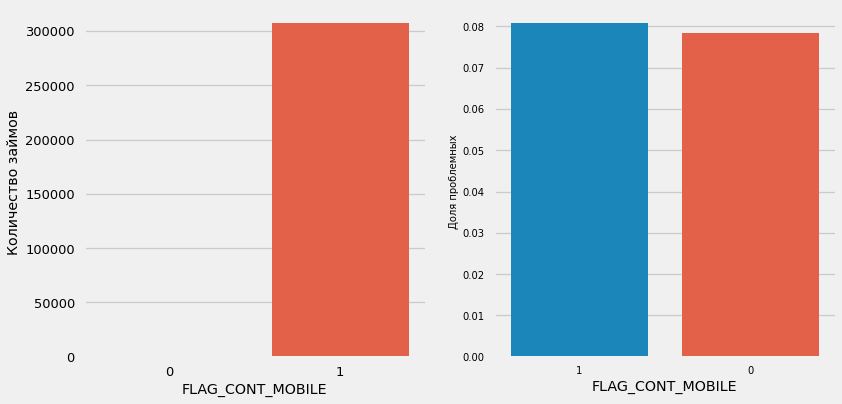

In [50]:
plot_stats('FLAG_CONT_MOBILE')

Люди в не зоны доступности телефона возвращают кредит примерно так же как и люди с доступом к телефонной связи.

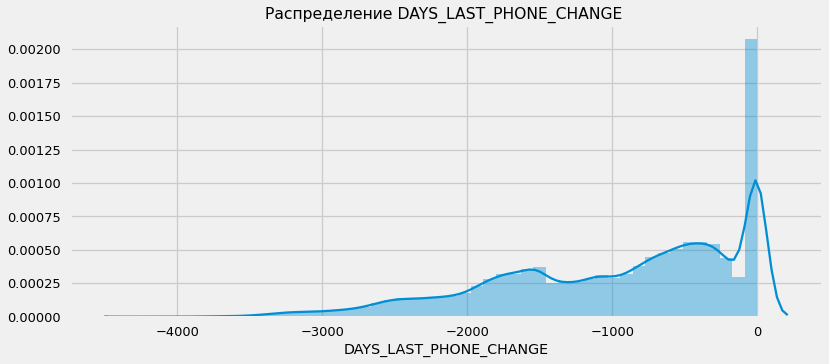

In [51]:
plt.figure(figsize=(12,5))
plt.title("Распределение DAYS_LAST_PHONE_CHANGE ")
ax = sns.distplot(app_train['DAYS_LAST_PHONE_CHANGE'])


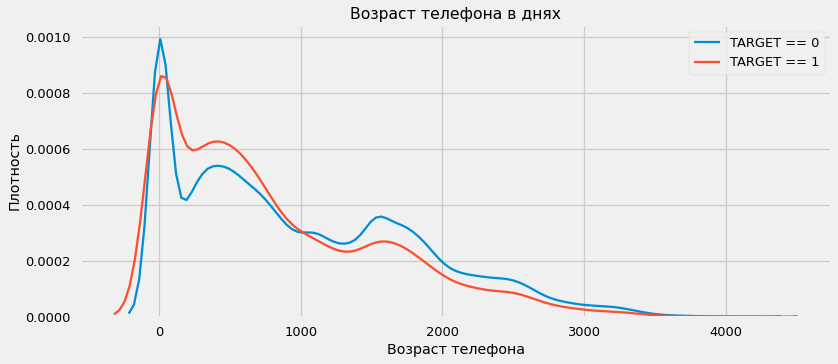

In [52]:
plt.figure(figsize=(12,5))

# KDE займов, выплаченных вовремя
sns.kdeplot(app_train.loc[app_train['TARGET']==0, 'DAYS_LAST_PHONE_CHANGE'].abs(), label='TARGET == 0')

# KDE проблемных займов
sns.kdeplot(app_train.loc[app_train['TARGET']==1, 'DAYS_LAST_PHONE_CHANGE'].abs(), label='TARGET == 1')

# Обозначения
plt.xlabel('Возраст телефона'); plt.ylabel('Плотность'); plt.title('Возраст телефона в днях');

## Feature Engineering - преобразование признаков

### Заполнение пропусков

In [53]:
from sklearn.impute import SimpleImputer

In [54]:
imputer = SimpleImputer(strategy='median', verbose=1)

train = imputer.fit_transform(train)
test = imputer.transform(test)

## Обучение моделей

In [55]:
# import gc
# gc.collect()

In [56]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, VotingClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import Normalizer
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [57]:
random_state = 23
n_folds = 5
scoring = 'roc_auc'

In [58]:
kfold = KFold(n_splits=n_folds, shuffle=True, random_state=random_state)

In [74]:
pipelines = []

# Normalization
# pipelines.append(('N_LR', Pipeline([('Scaler', Normalizer()), ('LR', LogisticRegression(random_state=random_state, C=1e-4))])))
# pipelines.append(('N_LDA', Pipeline([('Scaler', Normalizer()), ('LDA', LinearDiscriminantAnalysis())])))
# pipelines.append(('N_KNN', Pipeline([('Scaler', Normalizer()), ('KNN', KNeighborsClassifier())])))
# pipelines.append(('N_CART', Pipeline([('Scaler', Normalizer()), ('CART', DecisionTreeClassifier(random_state=random_state))])))
# pipelines.append(('N_NB', Pipeline([('Scaler', Normalizer()), ('NB', GaussianNB())])))
# pipelines.append(('N_LSVC', Pipeline([('Scaler', Normalizer()), ('LSVC', LinearSVC(random_state=random_state))])))
# pipelines.append(('N_SVC', Pipeline([('Scaler', Normalizer()), ('SVC', SVC(random_state=random_state))])))
# pipelines.append(('N_MLP', Pipeline([('Scaler', Normalizer()), ('MLP', MLPClassifier(random_state=random_state))])))
# pipelines.append(('N_BG', Pipeline([('Scaler', Normalizer()), ('BG', BaggingClassifier(n_estimators=100, random_state=random_state))])))
pipelines.append(('N_RF', Pipeline([('Scaler', Normalizer()), ('RF', RandomForestClassifier(random_state=random_state))])))                                                                                                                                                        
pipelines.append(('N_ET', Pipeline([('Scaler', Normalizer()), ('ET', ExtraTreesClassifier(random_state=random_state))])))
pipelines.append(('N_AB', Pipeline([('Scaler', Normalizer()), ('AB', AdaBoostClassifier(algorithm='SAMME', random_state=random_state))])))
pipelines.append(('N_GB', Pipeline([('Scaler', Normalizer()), ('GB', GradientBoostingClassifier(random_state=random_state))])))
pipelines.append(('N_LGBM', Pipeline([('Scaler', Normalizer()), ('LGBM', LGBMClassifier(random_state=random_state))])))

In [67]:
cv_results = []
for name, classifier in pipelines:
    print('\nTraining: {}'.format(name))
    cv_results.append(cross_val_score(classifier, train, y=Y, scoring=scoring, cv=kfold, n_jobs=-1))

cv_means = []
cv_std = []
for cv_result in cv_results:
    cv_means.append(cv_result.mean())
    cv_std.append(cv_result.std())


Training: N_LR

Training: N_LDA

Training: N_KNN

Training: N_CART

Training: N_NB

Training: N_LSVC

Training: N_RF

Training: N_ET

Training: N_AB

Training: N_GB

Training: N_LGBM


In [68]:
cv_res = pd.DataFrame({"CrossValMeans":cv_means,"CrossValerrors": cv_std,
                       "Algorithm":["LogisticRegression",
                                    "LinearDiscriminantAnalysis",
                                    "KNeighboors",
                                    "DecisionTree",
                                    "GaussianNB",
                                    "LinearSVC",
                                    "RandomForest",
                                    "ExtraTrees",
                                    "AdaBoost",
                                    "GradientBoosting",
                                    "LGBMClassifier"]})

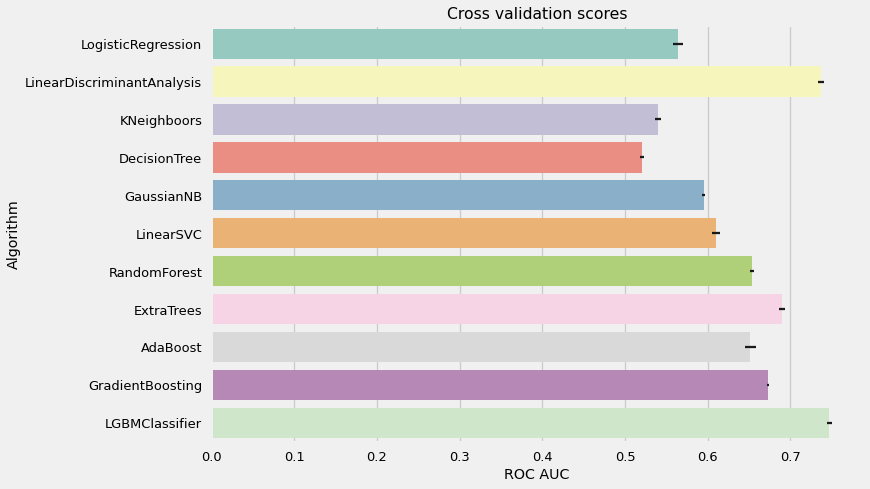

In [69]:
g = sns.barplot("CrossValMeans", "Algorithm", data = cv_res, palette="Set3",orient = "h",**{'xerr':cv_std})
g.set_xlabel("ROC AUC")
g = g.set_title("Cross validation scores")

In [ ]:
for name, model in pipelines:
    print(name)
    model.fit(train, Y)
    predictions = model.predict_proba(test)[:, 1]

    submit = app_test[['SK_ID_CURR']]
    submit['TARGET'] = predictions

    submit.to_csv('{}_baseline.csv'.format(name), index = False)

N_RF
